### prueba de parametros skopt

### 0. Load Kedro context:
- This is only necessary to run a notebook within a Kedro project, not needed in production code when running nodes/pipelines

In [17]:
# Load kedro environment (not needed in .py)
from pathlib import Path
from kedro.framework.context import load_context

# Load a context to be able to work in the notebook
#current_dir = Path.cwd()
current_dir = Path("/u01/share/cesar/aa_engine_uy/notebooks/")
proj_path = current_dir.parent
context = load_context(proj_path)
catalog = context.catalog
credentials = context.config_loader.get("credentials*","credentials*/**")
parameters = context.config_loader.get("parameters*","parameters*/**")
from re import search
import random
from aa_engine_pkg.assets.utils import *
from aa_engine_pkg.assets.core.data.kedro.catalog_expansion.partitioned_sql import SQLPartitionedDataSet
from sklearn import model_selection
from functools import partial
from skopt import space
from skopt import gp_minimize
from aa_engine_pkg.assets.utils import model_pipeline

In [3]:
# -------------------------------- XSELL MODEL --------------------------------
# Using temporal division
# Initialize logger
log = initialize_logger()
log.info(f"[TRAIN_MODEL] Creating model...")

# Loading parameters
model = "xsell"
model_type = "binary"
if model == "":
    model = parameters["models"]["model"]
if model_type == "":
    model = parameters["models"][model]["model_type"]
model_path = parameters["paths"]["model_path"]
n_threads = parameters["models"]["n_threads"]

random_time=False
downsample=False

2021-01-06 14:57:02,579 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Creating model...


In [4]:
train_periods = parameters["models"][model][model_type]["train_periods"]
dev_periods = parameters["models"][model][model_type]["dev_periods"]
test_periods = parameters["models"][model][model_type]["test_periods"]
id_vars = parameters["models"][model][model_type]["id_vars"]
period_vars = parameters["models"][model][model_type]["period_vars"]
target_var = parameters["models"][model][model_type]["target_var"]
score_var = parameters["models"][model][model_type]["score_var"]
load_subsample = parameters["models"][model][model_type]["load_subsample"]
fill_na_with = parameters["models"][model][model_type]["fill_na_with"]

In [5]:
test_periods

['20200615', '20200713', '20200810', '20200907']

In [6]:
if type(fill_na_with) == str:
    fill_na_with = eval(fill_na_with)

# Join periods
model_periods = list(np.unique(train_periods + dev_periods))
if len(model_periods) < (len(train_periods) + len(dev_periods)):
    log.warning(f"Validation periods and train periods overlap")

# Set maximum number of threads
os.environ["NUMEXPR_MAX_THREADS"] = str(n_threads)

### 1. Random periods and downsample

In [7]:
#Random periods
if random_time == True:
    random.seed(4)
    l=train_periods+dev_periods+test_periods
    ix=list(range(len(l)-1))
    sampled_list = random.sample(ix, int(0.8*len(ix)))
    train_list = [l[i] for i in sampled_list ] 
    test_list = [l[i] for i in ix if i not in sampled_list ] 
else:
    train_list=train_periods+dev_periods
    test_list=test_periods
    
print(f"----------- train periods -------------")
print(f"{train_list}")
print(f"----------- test periods -------------")
print(f"{test_list}")

----------- train periods -------------
['20181203', '20181231', '20190128', '20190225', '20190325', '20190422', '20190520', '20190617', '20190715', '20190812', '20190909', '20191007', '20191104', '20191202', '20191230', '20200127', '20200224', '20200323', '20200420', '20200518']
----------- test periods -------------
['20200615', '20200713', '20200810', '20200907']


In [8]:
test_list

['20200615', '20200713', '20200810', '20200907']

In [9]:
#Downsample
ratio_noevents_vs_events=4
if downsample==True:
    random.seed(4)
    df_all = load_and_merge_tables(model=model,
                                     model_type=model_type,
                                     periods=train_list+test_list,
                                     parameters=parameters,
                                     load_subsample=load_subsample,
                                     load_target=True)
    df_all.reset_index(drop=True,inplace=True)
    df_down_sample=[]
    for date in df_all.DATE_CALC.unique():
        if date not in test_list:
            idx_target=df_all.loc[(df_all.TARGET==1) & (df_all.DATE_CALC==date)].index
            n_target=df_all.loc[(df_all.TARGET==1) & (df_all.DATE_CALC==date)].shape[0]

            idx_no_target=df_all.loc[(df_all.TARGET==0) & (df_all.DATE_CALC==date)].index
            n_no_target=df_all.loc[(df_all.TARGET==0) & (df_all.DATE_CALC==date)].shape[0]
            
            n=np.where(n_target*ratio_noevents_vs_events<n_no_target,n_target*ratio_noevents_vs_events,n_no_target)

            random_indices = np.random.choice( idx_no_target, n , replace=False)
            down_sample_indices = np.concatenate([idx_target,random_indices])
            aux=df_all.loc[down_sample_indices].copy()
            
            print(f"ratio 1/0 {date}: { np.round(aux.TARGET.mean(),2) }")
            df_down_sample.append(aux)

        df_down=pd.concat(df_down_sample)
        df_train=df_down.loc[df_down.DATE_CALC.isin(train_list)].copy()
        
    df_test=df_all.loc[df_all.DATE_CALC.isin(test_list)].copy()
else:
    print("-----------No downsample ------------------")
    # Load datasets
    df_train = load_and_merge_tables(model=model,
                                     model_type=model_type,
                                     periods=train_list,
                                     parameters=parameters,
                                     load_subsample=load_subsample,
                                     load_target=True)
    print(f"ratio 1/0 {df_train.groupby('DATE_CALC').agg({'TARGET':'mean'})}")
    df_test = load_and_merge_tables(model=model,
                                    model_type=model_type,
                                    periods=test_list,
                                    parameters=parameters,
                                    load_subsample=False,
                                    load_target=True)

print(f"ratio 1/0 {df_test.groupby('DATE_CALC').agg({'TARGET':'mean'})}")

-----------No downsample ------------------
2021-01-06 14:57:35,455 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20181203
2021-01-06 14:57:37,051 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20181231
2021-01-06 14:57:39,013 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190128
2021-01-06 14:57:40,824 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190225
2021-01-06 14:57:41,941 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190325
2021-01-06 14:57:43,078 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190422
2021-01-06 14:57:44,272 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190520
2021-01-06 14:57:45,593 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190617
2021-01-06 14:57:47,190 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190715
2021-01-06 14:57:49,007 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190812
2021-01-06 14:57:51,046 - aa_engine_pkg.assets.utils.utilities - I

In [10]:
df_test.groupby("DATE_CALC").TARGET.sum()

DATE_CALC
20200615     959
20200713    1000
20200810     945
20200907    1069
Name: TARGET, dtype: int32

### For  xsell remove clients with all the premium

In [11]:
# Train
log.info(f"[TRAIN] Target pre-filtros: {df_train.groupby(target_var).size()/df_train.shape[0]*100}")
train_mask_has_all_premiums = (df_train["EOP_N_HBO"] >= 1)&(df_train["EOP_N_FOX"] >= 1)&(df_train["EOP_N_ADULTOS"] >= 1)
df_train = df_train.loc[~train_mask_has_all_premiums, :]
log.info(f"[TRAIN] Target post-filtros: {df_train.groupby(target_var).size()/df_train.shape[0]*100}")

#Test
log.info(f"[TEST] Target pre-filtros: {df_test.groupby(target_var).size()/df_test.shape[0]*100}")
test_mask_has_all_premiums = (df_test["EOP_N_HBO"] >= 1)&(df_test["EOP_N_FOX"] >= 1)&(df_test["EOP_N_ADULTOS"] >= 1)
df_test = df_test.loc[~test_mask_has_all_premiums, :]
log.info(f"[TEST] Target post-filtros: {df_test.groupby(target_var).size()/df_test.shape[0]*100}")

2021-01-06 15:02:22,435 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN] Target pre-filtros: TARGET
0    98.871593
1     1.128407
dtype: float64
2021-01-06 15:02:27,693 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN] Target post-filtros: TARGET
0    98.857883
1     1.142117
dtype: float64
2021-01-06 15:02:27,705 - aa_engine_pkg.assets.utils.utilities - INFO - [TEST] Target pre-filtros: TARGET
0    99.144815
1     0.855185
dtype: float64
2021-01-06 15:02:28,578 - aa_engine_pkg.assets.utils.utilities - INFO - [TEST] Target post-filtros: TARGET
0    99.133964
1     0.866036
dtype: float64


### 2. Split

In [19]:
# Split train and dev sets
X_train, X_dev, y_train, y_dev = model_pipeline.create_train_test_datasets(df_train, df_train[target_var], test_size=0.2)
df_train = X_train
df_train[target_var] = y_train
df_dev = X_dev
df_dev[target_var] = y_dev
del X_train, y_train, X_dev, y_dev; gc.collect()

if model_type == "binary":
    for df, name in zip([df_train, df_dev, df_test], ["TRAIN", "DEV", "TEST"]):
        log.info(f"{name}:")
        log.info(pd.crosstab(df["DATE_CALC"], df["TARGET"]).reset_index().apply(lambda x: x[1] / (x[1] + x[0]),axis=1))
            
elif model_type == "multiclass":
    for df, name in zip([df_train, df_dev, df_test], ["TRAIN", "DEV", "TEST"]):
        for idx, cat in enumerate(df[target_var].unique()):
            log.info(f"{name}:")
            log.info(f"{cat}:")
            log.info(pd.crosstab(df["DATE_CALC"], df[target_var]).apply(lambda x: x[idx] / (x[0] + x[1] + x[2]), axis=1))



2021-01-06 15:15:21,724 - aa_engine_pkg.assets.utils.utilities - INFO - TRAIN:
2021-01-06 15:15:21,920 - aa_engine_pkg.assets.utils.utilities - INFO - 0     0.014175
1     0.011579
2     0.013595
3     0.015119
4     0.017829
5     0.014411
6     0.013666
7     0.008346
8     0.009771
9     0.009116
10    0.010052
11    0.010986
12    0.010791
13    0.008884
14    0.010152
15    0.009877
16    0.012996
17    0.010907
18    0.008397
19    0.008379
dtype: float64
2021-01-06 15:15:21,923 - aa_engine_pkg.assets.utils.utilities - INFO - DEV:
2021-01-06 15:15:21,979 - aa_engine_pkg.assets.utils.utilities - INFO - 0     0.012383
1     0.012268
2     0.014316
3     0.014533
4     0.018380
5     0.012730
6     0.012779
7     0.008617
8     0.009257
9     0.010280
10    0.010021
11    0.009656
12    0.009724
13    0.011544
14    0.010627
15    0.010321
16    0.013317
17    0.009914
18    0.008175
19    0.009080
dtype: float64
2021-01-06 15:15:21,982 - aa_engine_pkg.assets.utils.utilities - INFO 

In [20]:
# Exclude vars
vars_to_exclude = []
num_vars = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Select vars to use for training
vars_to_model = list(set(num_vars) - set(id_vars + period_vars + [target_var] + vars_to_exclude))

del df; gc.collect()

df_dev = add_selected_variables(df_dev, vars_to_model, fill_na_with)
df_test = add_selected_variables(df_test, vars_to_model, fill_na_with)

[] not found in df
[] not found in df


In [21]:
# LGB datasets
if model_type == "multiclass":
    xlgb_train = lgbm.Dataset(df_train[vars_to_model], label=df_train[target_var].cat.codes)
    xlgb_dev = lgbm.Dataset(df_dev[vars_to_model], label=df_dev[target_var].cat.codes)
elif model_type == "binary":
    xlgb_train = lgbm.Dataset(df_train[vars_to_model], label=df_train[target_var])
    xlgb_dev = lgbm.Dataset(df_dev[vars_to_model], label=df_dev[target_var])
valid_sets = [xlgb_train, xlgb_dev]
log.info(f"[TRAIN_MODEL] Training model")

2021-01-06 15:16:21,726 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Training model


### 3. Using Bayesian Optimization

keaggle example: [link1](https://www.kaggle.com/a31314431/bayesian-optimization-lightgbm)


youtube: [link2](https://www.youtube.com/watch?v=5nYqK-HaoKY)

### 3.1 check params [link](https://colab.research.google.com/github/lmassaron/kaggledays-2019-gbdt/blob/master/Kaggle%20Days%20Paris%20-%20%20GBDT%20workshop.ipynb#scrollTo=dJI3_YbYVzBb)

In [27]:
#List of search space dimensions
param_space=[
     #space.Categorical(["goss","gbdt"], name='boosting_type'),
     space.Categorical(["gbdt"], name='boosting_type'),
     space.Real(10**-2, 10**0, "log-uniform", name='learning_rate'),
     space.Integer(3,7,prior="uniform",name="feature_fraction"),
     space.Integer(3,7,prior="uniform",name="bagging_fraction"),
     space.Integer(3,15,name="num_leaves"),
     space.Integer(3,10,name="min_child_weight"),
 ]

#### self-defined eval metric
#### Precision-Recall Curves and AUC
Precision is a metric that quantifies the number of correct positive predictions made.
It is calculated as the number of true positives divided by the total number of true positives and false positives.
Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.
Both the precision and the recall are focused on the positive class (the minority class) and are unconcerned with the true negatives (majority class).
[check](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/#:~:text=The%20Precision%2DRecall%20AUC%20is,a%20model%20with%20perfect%20skill)

In [25]:
# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, eval_result: float, is_higher_better: bool
# binary error
# NOTE: when you do customized loss function, the default prediction value is margin
# This may make built-in evalution metric calculate wrong results
# For example, we are doing log likelihood loss, the prediction is score before logistic transformation
# Keep this in mind when you use the customization
def f_pr_auc(probas_pred, y_true):
    probas_pred=1. / (1. + np.exp(-probas_pred))
    labels=y_true.get_label()
    p, r, _ = skmetrics.precision_recall_curve(labels, probas_pred)
    score=skmetrics.auc(r,p)
    return "pr_auc", score, True

In [28]:
def var_to_minimize(param):
    
    model_params= {
    "boosting_type": param[0],
    "objective": "binary",
    "metric": ["auc"],
    "seed": 9520,
    "learning_rate": param[1],
    "feature_fraction": param[2]/10,
    "bagging_fraction": param[3]/10,
    "num_leaves": param[4],
    "min_child_weight": param[5],
    "num_threads": n_threads}
    
    log.info(f"[TRAIN_MODEL] Training model")
    print('\nNext set of params.....',model_params)
    
    eval_results = {}
    cb_evaluation = lgbm.record_evaluation(eval_results)
    # Train model
    lgbmodel = lgbm.train(model_params,
                          xlgb_train,
                          valid_sets=valid_sets,
                          #feval =f_pr_auc,
                          early_stopping_rounds=10,
                          verbose_eval=False,
                          num_boost_round=500,
                          callbacks=[cb_evaluation])
    
    preds=lgbmodel.predict(df_test[vars_to_model])
    metric=skmetrics.roc_auc_score(df_test[target_var], preds)
    
    p, r, _=skmetrics.precision_recall_curve(df_test[target_var], preds)
    pr_auc=skmetrics.auc(r,p)
    
   
    print(f"auc roc: {np.round(metric,4)} | auc pr: {np.round(pr_auc,4)} | ratio of the test set {np.round(df_test.TARGET.mean(),4)} | iteration: {lgbmodel.current_iteration()}")
    return -1*(metric)

In [29]:
res_gp = gp_minimize(var_to_minimize, 
                     param_space, n_calls=100,
                     random_state=0,n_random_starts=10)

2021-01-06 15:18:03,953 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Training model


/u01/miniconda3/envs/uypo37/lib/python3.7/site-packages/skopt/optimizer/base.py:235: DeprecationWarning: n_random_starts will be removed in favour of n_initial_points. It overwrites n_initial_points.
  DeprecationWarning)



Next set of params..... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['auc'], 'seed': 9520, 'learning_rate': 0.4881255012149711, 'feature_fraction': 0.6, 'bagging_fraction': 0.6, 'num_leaves': 10, 'min_child_weight': 6, 'num_threads': 28}
auc roc: 0.7011 | auc pr: 0.0183 | ratio of the test set 0.0087 | iteration: 20
2021-01-06 15:18:50,352 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Training model

Next set of params..... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['auc'], 'seed': 9520, 'learning_rate': 0.012984521643751776, 'feature_fraction': 0.4, 'bagging_fraction': 0.5, 'num_leaves': 13, 'min_child_weight': 6, 'num_threads': 28}
auc roc: 0.7072 | auc pr: 0.0187 | ratio of the test set 0.0087 | iteration: 500
2021-01-06 15:21:57,639 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Training model

Next set of params..... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['auc'], 'seed': 9520, 'learning_rate': 0.4

In [30]:
"Best score=%.4f" % res_gp.fun

'Best score=-0.7124'

### 3. Training model with the best params

In [31]:
model_parameters= {
    "boosting_type": res_gp.x[0],
    "objective": "binary",
    "metric": ["auc"],
    "seed": 9520,
    "learning_rate": res_gp.x[1],
    "feature_fraction": res_gp.x[2]/10,
    "bagging_fraction": res_gp.x[3]/10,
    "num_leaves": res_gp.x[4],
    "min_child_weight": res_gp.x[5],
    "num_threads": n_threads}
model_parameters

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': ['auc'],
 'seed': 9520,
 'learning_rate': 0.028100424507357526,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.7,
 'num_leaves': 15,
 'min_child_weight': 10,
 'num_threads': 28}

In [32]:
eval_results = {}
cb_evaluation = lgbm.record_evaluation(eval_results)
lgbmodel = lgbm.train(model_parameters,
                      xlgb_train,
                      valid_sets=valid_sets,
                      early_stopping_rounds=10,
                      verbose_eval=10,
                      num_boost_round=500,
                      callbacks=[cb_evaluation])
preds=lgbmodel.predict(df_test[vars_to_model])
metric=skmetrics.roc_auc_score(df_test[target_var], preds)

p, r, _=skmetrics.precision_recall_curve(df_test[target_var], preds)
pr_auc=skmetrics.auc(r,p)

print(f"TEST auc roc: {np.round(metric,4)} | auc pr: {np.round(pr_auc,4)} | ratio of the test set {np.round(df_test.TARGET.mean(),4)} | iteration: {lgbmodel.current_iteration()}")

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.673381	valid_1's auc: 0.664319
[20]	training's auc: 0.685073	valid_1's auc: 0.674662
[30]	training's auc: 0.690094	valid_1's auc: 0.678742
[40]	training's auc: 0.69502	valid_1's auc: 0.682499
[50]	training's auc: 0.699017	valid_1's auc: 0.685504
[60]	training's auc: 0.702134	valid_1's auc: 0.687756
[70]	training's auc: 0.705213	valid_1's auc: 0.690023
[80]	training's auc: 0.707563	valid_1's auc: 0.69131
[90]	training's auc: 0.709927	valid_1's auc: 0.692912
[100]	training's auc: 0.712126	valid_1's auc: 0.69451
[110]	training's auc: 0.714085	valid_1's auc: 0.695983
[120]	training's auc: 0.715907	valid_1's auc: 0.697086
[130]	training's auc: 0.717431	valid_1's auc: 0.697976
[140]	training's auc: 0.719181	valid_1's auc: 0.699175
[150]	training's auc: 0.720778	valid_1's auc: 0.700094
[160]	training's auc: 0.722198	valid_1's auc: 0.701028
[170]	training's auc: 0.723458	valid_1's auc: 0.701794
[180]	training's

                                                column  importance_gain
162                                          EOP_N_HBO         0.083652
169                                          EOP_N_FOX         0.073242
128                                         EOP_TENURE         0.058926
537                      SAC_N_CONT_CAT_0105_nansum_84         0.037095
329                                    MUD_DAYS_nanmax         0.024869
923                 EVE_CAT_COMBINED_5229_1_nansum_252         0.022124
216                EVE_CAT_COMBINED_100142_1_nansum_84         0.020150
193                                           CLI_EDAD         0.018138
869               EVE_CAT_COMBINED_100142_1_nansum_336         0.016479
121                   EVE_CAT_COMBINED_142_1_nansum_28         0.015408
509                                 AQY_RATIO_ARPU_1_3         0.014309
412                                 AQY_ARPU_nanmean_1         0.012413
150                SAC_N_CONT_SUBCAT_0105001_nansum_84         0

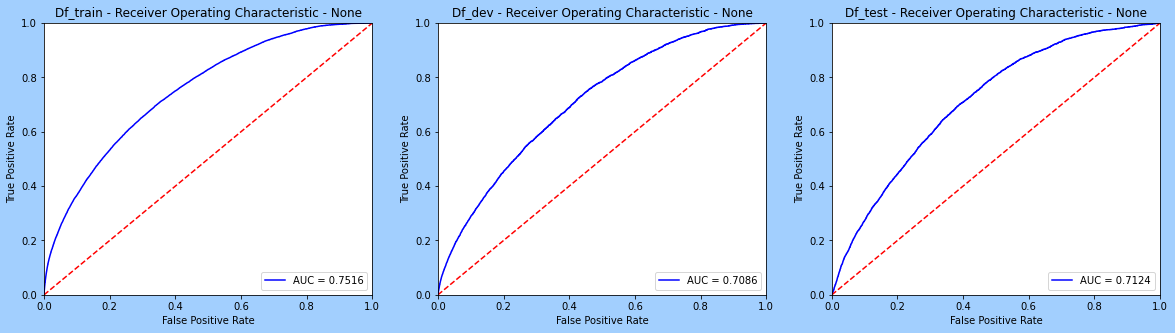

In [33]:
# Create model path
model_format = datetime.strftime(datetime.today(), "%Y%m%d_%H%M")
model_folder = f"{model_path}{model_format}_{model}_{model_type}_model/"

if not os.path.exists(model_folder):
    os.makedirs(model_folder)

importance_lgbm = lgbmodel.feature_importance(importance_type="gain")
df_importance_lgbm = pd.DataFrame(
    {'column': list(df_train[vars_to_model].columns),
     'importance_gain': importance_lgbm})
df_importance_lgbm.sort_values('importance_gain', ascending=False, axis=0, inplace=True)
df_importance_lgbm['importance_gain'] = df_importance_lgbm['importance_gain'] / \
                                        df_importance_lgbm['importance_gain'].sum()
# Export variable importance
df_importance_lgbm.to_csv(model_folder + model_format + "_important_variables.csv", sep=";", decimal=".", index=False)

print(df_importance_lgbm.head(30))

export_auc_graph(df_train=df_train,
                 df_dev=df_dev,
                 df_test=df_test,
                 model=lgbmodel,
                 vars_to_model=vars_to_model,
                 target_var=target_var,
                 file_path=model_folder + model_format + "_auc.png",
                 multiclass=False)

In [34]:
# Export model performance
export_model_performance_lgbm(model=lgbmodel,
                              vars_to_include=vars_to_model,
                              target_var=target_var,
                              id_var=id_vars,
                              period_var=period_vars,
                              score_var=score_var,
                              df=df_train,
                              table_name="train",
                              model_folder=model_folder,
                              model_format=model_format,
                              export_df=False)
export_model_performance_lgbm(model=lgbmodel,
                              vars_to_include=vars_to_model,
                              target_var=target_var,
                              id_var=id_vars,
                              period_var=period_vars,
                              score_var=score_var,
                              df=df_dev,
                              table_name="dev",
                              model_folder=model_folder,
                              model_format=model_format,
                              export_df=False)

export_model_performance_lgbm(model=lgbmodel,
                              vars_to_include=vars_to_model,
                              target_var=target_var,
                              id_var=id_vars,
                              period_var=period_vars,
                              score_var=score_var,
                              df=df_test,
                              table_name="test",
                              model_folder=model_folder,
                              model_format=model_format,
                              export_df=True,
                              N=20)

df_explore = df_test.copy()
df_explore[score_var] = lgbmodel.predict(df_test[vars_to_model])

df_summary = variable_avg_by_ntile(df_explore,
                                   N=10,
                                   score_col=score_var,
                                   feature_importance=df_importance_lgbm)

df_summary.to_csv(model_folder + model_format + "_summary.csv", sep=";", decimal=",", index=False)

# Export volumes
df_volume = get_model_volumes(df_train=df_train,
                              df_dev=df_dev,
                              df_test=df_test,
                              period_var="DATE_CALC",
                              target_var=target_var)
df_volume.to_csv(model_folder + model_format + "_volumes.csv", sep=";", decimal=",", index=False)

# Save parameteres
save_json(model_parameters, model_folder + model_format + "_model_parameters.json")

df = []
vars_to_analyze = df_importance_lgbm[df_importance_lgbm["importance_gain"] > 0]["column"].values.tolist()

df_list = [df_train[period_vars + vars_to_analyze],
           df_dev[period_vars + vars_to_analyze],
           df_test[period_vars + vars_to_analyze]]
df = pd.concat(df_list)
df = df.groupby(period_vars).agg(np.nanmean).T.reset_index().rename(columns={"index": "column"})
df = pd.merge(df, df_importance_lgbm, on="column", how="inner")
df.to_csv(model_folder + model_format + "_mean_evolution.csv", sep=";", decimal=",")

# Calculate NaN evolution
df = []
vars_to_analyze = df_importance_lgbm[df_importance_lgbm["importance_gain"] > 0]["column"].values.tolist()

df_list = [df_train[period_vars + vars_to_analyze],
           df_dev[period_vars + vars_to_analyze],
           df_test[period_vars + vars_to_analyze]]
df = pd.concat(df_list)
df = df.groupby(period_vars).agg(lambda x: x.isnull().sum()/len(x)).T.reset_index().rename(columns={"index": "column"})
df = pd.merge(df, df_importance_lgbm, on="column", how="inner")
df.to_csv(model_folder + model_format + "_nan_evolution.csv", sep=";", decimal=",")

# Calculate NaNs by decile
df_explore = get_ntile(df_explore,
                       N=10,
                       score_col=score_var,
                       ntile_col="DECIL")

df_explore_grouped = df_explore[period_vars + vars_to_analyze + ["DECIL"]].groupby("DECIL").agg(lambda x: x.isnull().sum()/len(x)
                                                                                               ).T.reset_index(
                                                                                               ).rename(columns={"index": "column"})

df_explore_grouped = pd.merge(df_explore_grouped, df_importance_lgbm, on="column", how="inner")
df_explore_grouped.to_csv(model_folder + model_format + "_nan_summary.csv", sep=";", decimal=",")